# Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
import pandas as pd
import pyplot_themes as themes
import sys 

# Turn off value-on-slice warning
pd.options.mode.chained_assignment = None  # default='warn'

def make_aesthetic():
    sns.set(style='white', context='poster')
    themes.theme_few('dark')
    plt.rcParams.update({'font.family':'Arial'})

# Prepare data

In [3]:
# (0,3) default 
# Note: (0,3) may be an anomaly. I found that increasing N or DATE_FINDER means that there's still a large interaction (t~7, ~ 33 p.p)
# but you get significant differences for web and YT so maybe need to just do Monte Carlo if can't pick 1 specific setup

N = 0 # Window around rumor/announcement to determine rumor_period/announcement_period 
DATE_FINDER = 3 # Window around rumor day to find 'actual' rumor day


OUTPUT_PATH = f"../../results/graphs/{N}_{DATE_FINDER}" # Where to save folders 

def make_max_value_dates(df, N):
    """
    Since it's not clear what the exact rumor day is, look at rumor days around GPT-generated rumor day and get 
    the one with max value
    """
    max_rumor_date = {}
    for uid in set(df['kwe'].tolist()):
        max_rumor_date[uid] = max_value_date_helper(df, uid, DATE_FINDER)
    return max_rumor_date

def max_value_date_helper(df, uid, N):
    """Helper function to max_value_dates"""
    df2 = df[df['kwe'] == uid]
    df2['abs_rumor_delta'] = np.abs(df2['rumor_delta'])
    filter_df = df2[df2['abs_rumor_delta'] <= N]
    max_date = filter_df.sort_values(['value', 'abs_rumor_delta'], ascending=False).head(1)['date'].tolist()[0]
    return max_date

def truncate_time(x, n, mode='only_forward'):
    if mode=='only_forward':
        if x >= 0 and x<= n:
            return 1 
        else:
            return 0
    
    elif mode == 'either_side':
        if abs(x)<= n:
            return 1 
        else:
            return 0
    else:
        return -9


# Read in data
rumor_data = pd.read_json("../../data/rum_data.json").T.reset_index()[['index', 'rumor_day', 'announce_day']]
df = pd.merge(left=pd.read_csv("../../data/trend_data_news.csv"), right=rumor_data, left_on='event', right_on='index')
df['search_type'] = df['search_type'].apply(lambda x: x if x!= 'news' else 'google_news')


# Make UID: kw + event
df['kwe'] = df['kw'] + "_" + df['event']

# Get date difference between date and rumor, announcement day
df['rumor_delta'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['rumor_day'])).dt.days.astype(int)
df['announce_delta'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['announce_day'])).dt.days.astype(int)
max_value_rumor_dict = make_max_value_dates(df, N)

# Also define a second rumor date from max_value function
df['rumor_day2'] = [max_value_rumor_dict[x] for x in df['kwe'].tolist()]
df['rumor2_delta'] = (pd.to_datetime(df['date']) - pd.to_datetime(df['rumor_day2'])).dt.days.astype(int)

# Get various other date differences and metadata
df['rumor_announce_gap'] = (pd.to_datetime(df['announce_day']) - pd.to_datetime(df['rumor_day'])).dt.days.astype(int)
df['max_date'] = df.groupby("event")['date'].transform('max')
df['min_date'] = df.groupby("event")['date'].transform('min')
df['study_duration'] = (pd.to_datetime(df['max_date']) - pd.to_datetime(df['min_date'])).dt.days.astype(int)
df['n_event_kws'] = df.groupby("event")['kw'].transform(lambda x: len(set(x)))
                                                    
# Various pivot tables
searchd = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2', 'announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
kwd = df.groupby(by=['event', 'date', 'kw', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
eventd = df.groupby(by=['event', 'date', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()
event_search = df.groupby(by=['event', 'date', 'search_type', 'rumor_day', 'rumor_day2','announce_day', 'rumor_delta', 'announce_delta']).mean().reset_index()

# Add features to DFs
for d in [df, kwd, eventd, searchd, event_search]:
    d['rumor_period'] = d['rumor_delta'].apply(lambda x: truncate_time(x, N))
    d['announce_period'] = d['announce_delta'].apply(lambda x: truncate_time(x, N))
    d['rumor2_period'] = d['rumor2_delta'].apply(lambda x: truncate_time(x, N))
    d['control_period'] = (d['rumor_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)
    d['control_period2'] = (d['rumor2_period'] + d['announce_period']).apply(lambda x: 1 if x==0 else 0)
    d['period'] = d.apply(lambda row: 'rumor_period' if row['rumor_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)
    d['period2'] = d.apply(lambda row: 'rumor2_period' if row['rumor2_period']==1 else ('announce_period' if row['announce_period']==1 else 'control'), axis=1)
    d['year'] = pd.to_datetime(d['rumor_day']).dt.year
    if 'kw' in d.columns:
        d['val_prop'] = d['value']/d.groupby(['kw', 'event'])['value'].transform('sum')
    if "search_type" in d.columns:
        d['search_type'] = pd.Categorical(d['search_type'],
                                   categories=["web", "google_news", "youtube"],
                                   ordered=True)
        

# Let's just make sure we got values for every kw/search combo    
grouped = df.groupby(['kwe'])['value'].max().reset_index()
no_nan_val = sum(grouped['value'].isna()) == 0 # No KWxSearchType is nan
every_kw_has_100 = np.min(grouped['value'])==100 # For every KW x SearchType there's a peak 
print("No Nans:", no_nan_val)
print("Every kw/search type has one pt which hits 100:", every_kw_has_100)
if (no_nan_val and every_kw_has_100):
    print("Proceed...data is valid")

No Nans: True
Every kw/search type has one pt which hits 100: True
Proceed...data is valid


# Basic Stats

In [4]:
print("OBS:", len(df), "\n")
print("EVENTS AND KEYWORDS")
print(df[['event', 'kw']].describe())
print()
print("STUDY PERIOD LENGTHS")
print(df[['rumor_announce_gap', 'study_duration', 'n_event_kws']].describe())

OBS: 16314 

EVENTS AND KEYWORDS
                     event            kw
count                16314         16314
unique                  26            62
top     Steve_Council_2017  donald trump
freq                   864           432

STUDY PERIOD LENGTHS
       rumor_announce_gap  study_duration   n_event_kws
count        16314.000000    16314.000000  16314.000000
mean            25.975359       85.975359      2.632218
std             13.507871       13.507871      0.624757
min              7.000000       67.000000      1.000000
25%             13.000000       73.000000      2.000000
50%             27.000000       87.000000      3.000000
75%             33.000000       93.000000      3.000000
max             56.000000      116.000000      4.000000


# Descriptive Plots

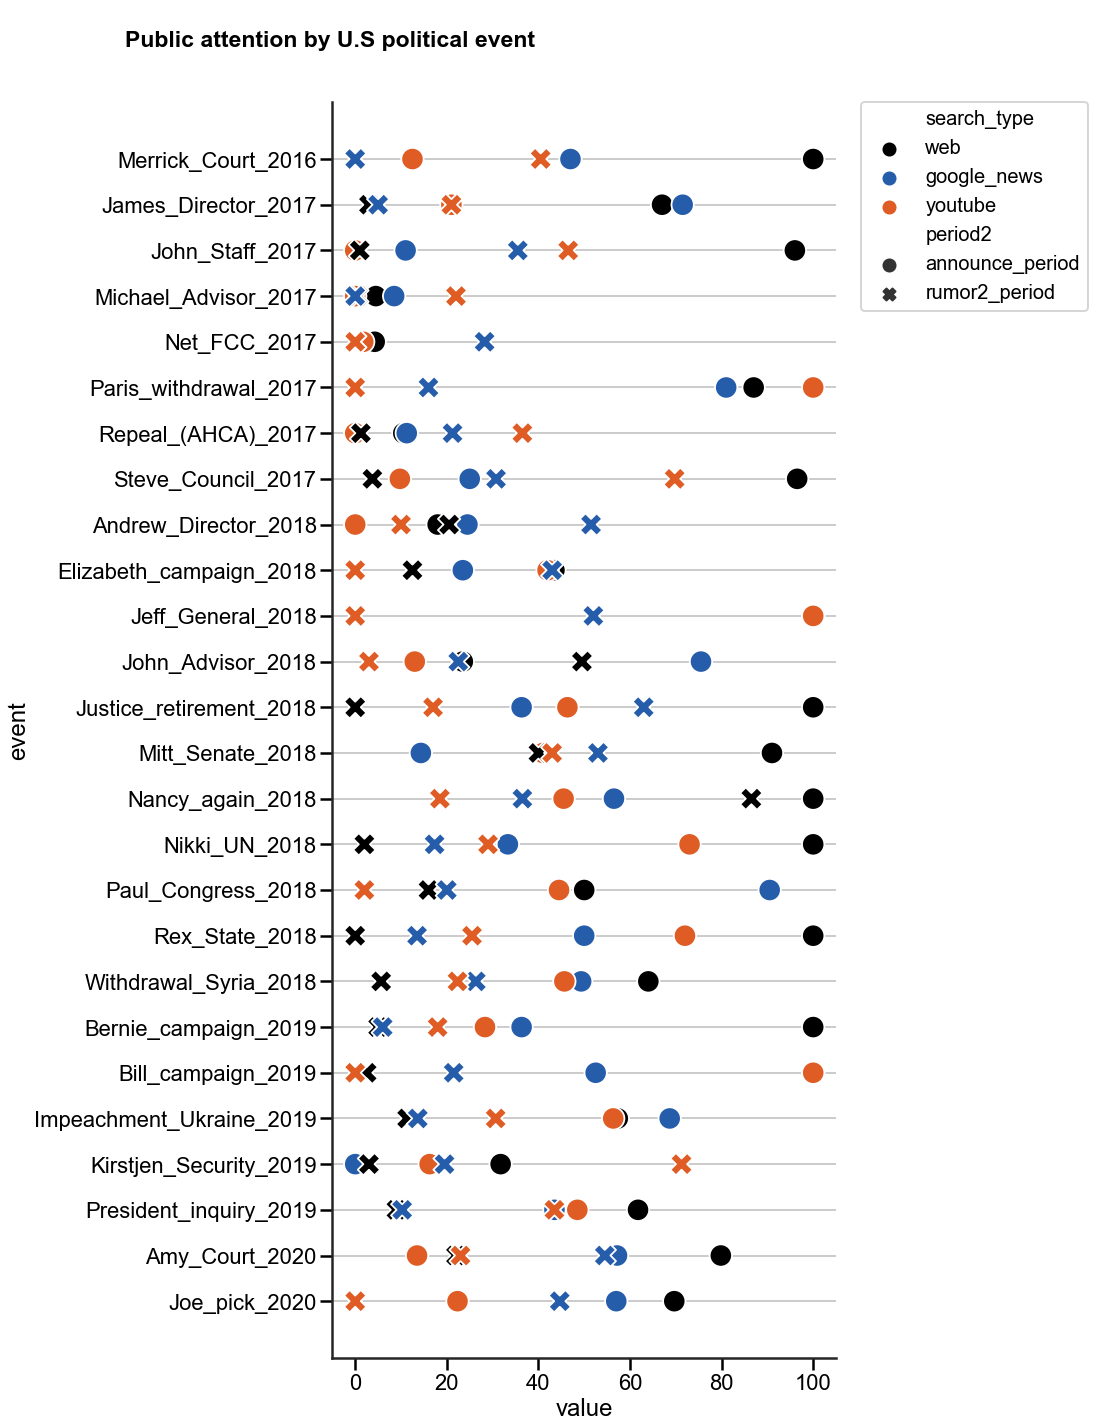

In [5]:
plt.figure(figsize=(16,20))
make_aesthetic()
edf = event_search.groupby(by=['period2', 'event', 'search_type']).mean().reset_index()
sns.scatterplot(data=edf.query("control_period2==0").sort_values(by=['year', 'event']), 
                y='event', s=500, 
                x='value', 
                style='period2',
                hue='search_type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20, markerscale=1)

plt.suptitle(
    "\nPublic attention by U.S political event",
    fontsize=23,
    fontweight="bold",
    x=0.125,
    y=1,
    ha="left",
)
plt.tight_layout()
plt.grid(linewidth=2, axis='y')  #just add this
sns.despine()
plt.savefig(f"{OUTPUT_PATH}all_events.png", dpi=300, bbox_inches='tight')

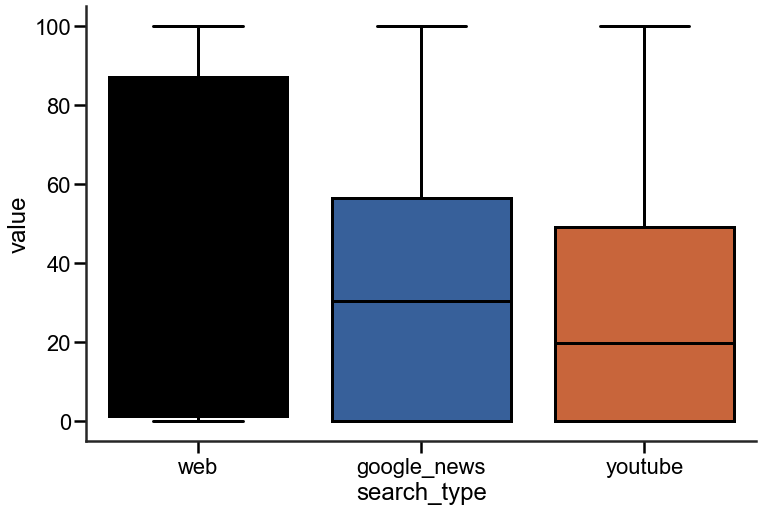

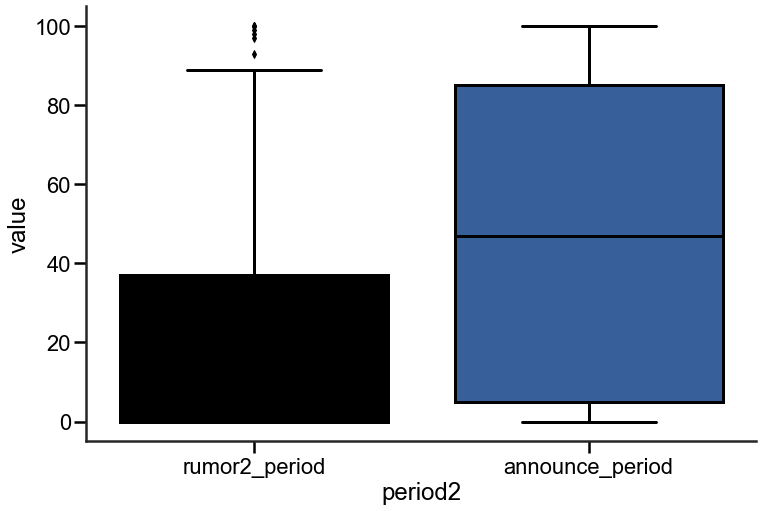

In [6]:
for break_out in ['search_type', 'period2']:
    make_aesthetic()
    sns.boxplot(data=event_search.query("control_period2==0"), x=break_out, y='value')
    sns.despine()
    plt.show()

# Announcement Period X Search Type

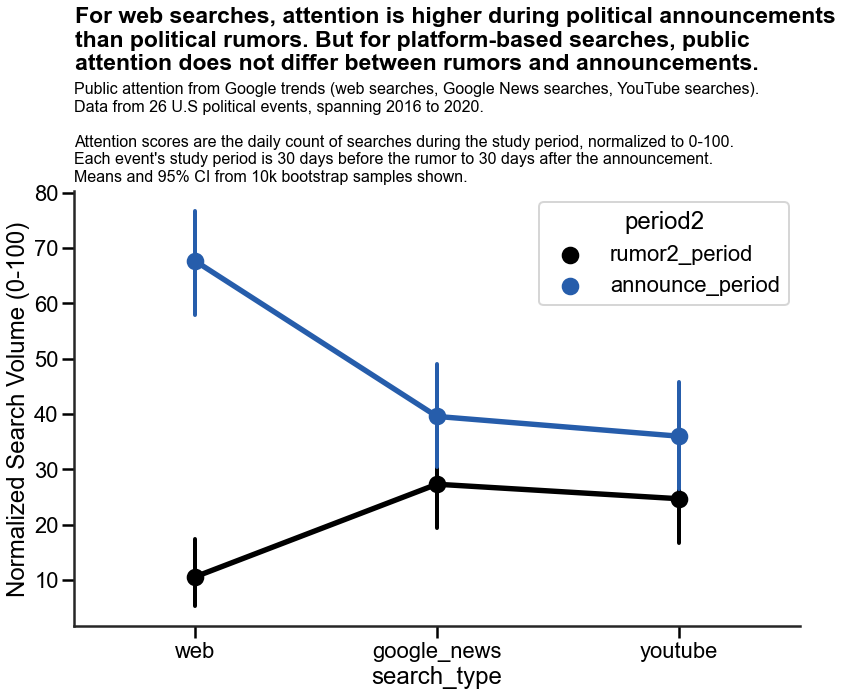

In [12]:
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager

make_aesthetic()

plt.figure(figsize=(13,8))

sns.pointplot(data=event_search.query("control_period2==0"), 
              errwidth=4, 
              errorbar='ci', 
              scale=1, 
              seed=416,
              n_boot=10000,
              hue='period2', 
              x='search_type', 
              y='value')


plt.ylabel("Normalized Search Volume (0-100)")

plt.title(
    (f"""\nPublic attention from Google trends (web searches, Google News searches, YouTube searches).\nData from {event_search['event'].nunique()} U.S political events, spanning {np.min(event_search['year'])} to {np.max(event_search['year'])}.\n\nAttention scores are the daily count of searches during the study period, normalized to 0-100.\nEach event's study period is 30 days before the rumor to 30 days after the announcement.\nMeans and 95% CI from 10k bootstrap samples shown."""),
    fontsize=16,
    pad=10,
    loc="left",
)


plt.suptitle(
    "For web searches, attention is higher during political announcements\nthan political rumors. But for platform-based searches, public\nattention does not differ between rumors and announcements.",
    fontsize=23,
    fontweight="bold",
    x=0.126,
    y=1.2,
    ha="left",
)

sns.despine()
plt.savefig(f"{OUTPUT_PATH}attn_interaction.png", dpi=300, bbox_inches='tight')


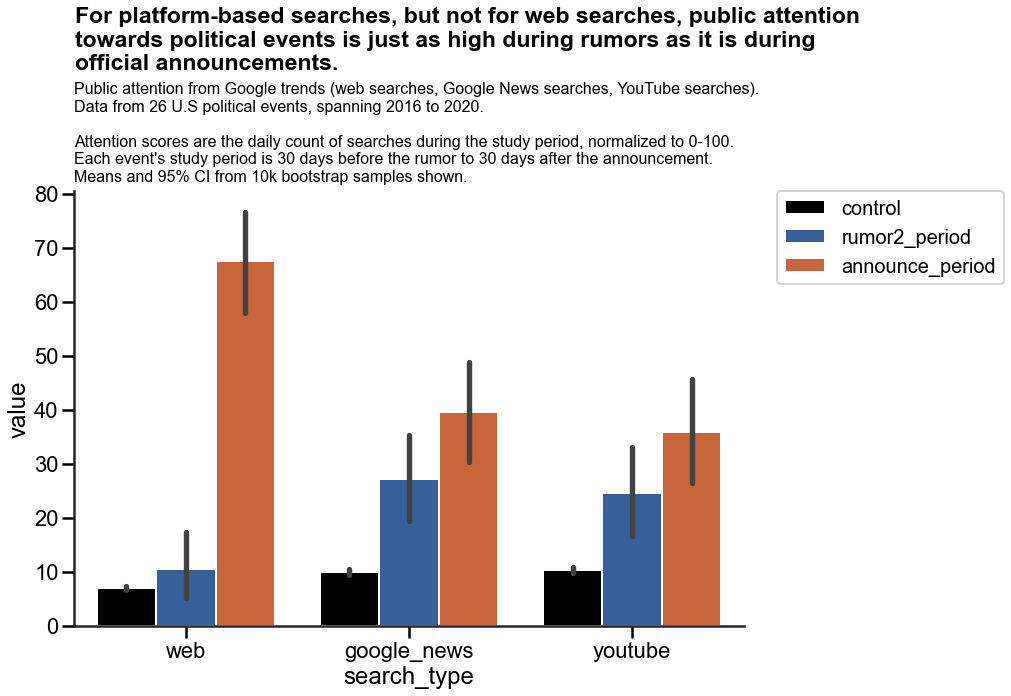

In [13]:
make_aesthetic()

sns.barplot(data=event_search.query("control_period2!=100"), 
              hue='period2', 
              x='search_type', 
              y='value', 
            ci=95,
           n_boot=10000, 
            seed=416)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20, markerscale=1)
plt.title(
    (f"""\nPublic attention from Google trends (web searches, Google News searches, YouTube searches).\nData from {event_search['event'].nunique()} U.S political events, spanning {np.min(event_search['year'])} to {np.max(event_search['year'])}.\n\nAttention scores are the daily count of searches during the study period, normalized to 0-100.\nEach event's study period is 30 days before the rumor to 30 days after the announcement.\nMeans and 95% CI from 10k bootstrap samples shown."""),
    fontsize=16,
    pad=10,
    loc="left",
)

plt.suptitle(
    "For platform-based searches, but not for web searches, public attention\ntowards political events is just as high during rumors as it is during\nofficial announcements.",
    fontsize=23,
    fontweight="bold",
    x=0.126,
    y=1.2,
    ha="left",
)
sns.despine()
plt.savefig(f"{OUTPUT_PATH}attn_bars.png", dpi=300, bbox_inches='tight')


# Get beta coefficients (but mixed fx didn't converge, and use EMM in R for real)

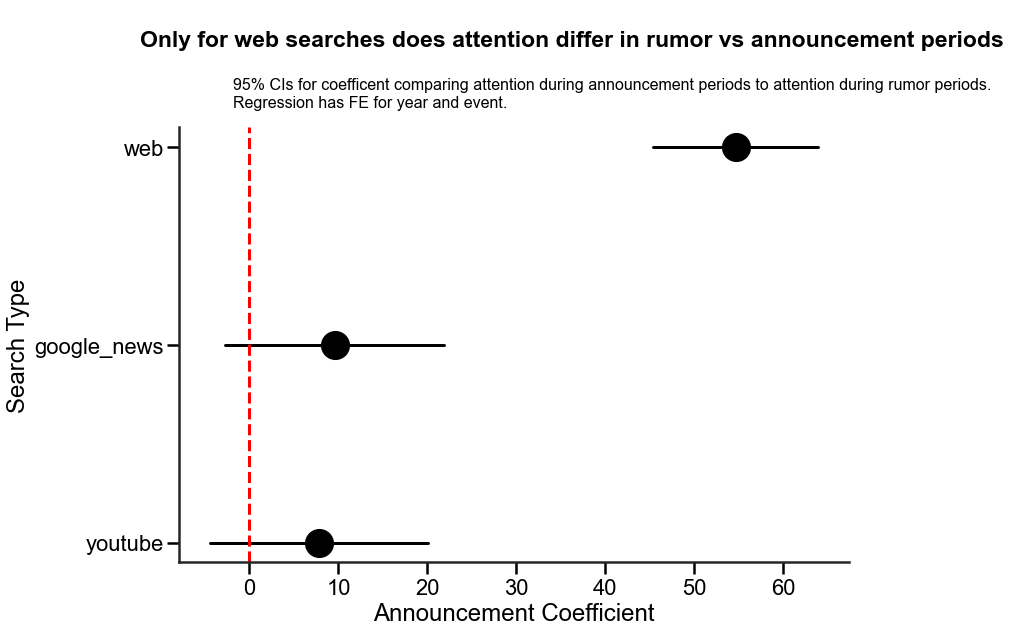

In [14]:

beta_dfs = []
for search_type in set(df['search_type'].tolist()):
    tdf = df.query("search_type=='{}'&period2!='control'".format(search_type))
    md = smf.ols("value ~ C(year) + C(period2, Treatment('rumor2_period')) + C(event)", tdf).fit()

    coef_period2 = md.params["C(period2, Treatment('rumor2_period'))[T.announce_period]"]
    conf_int_period2 = md.conf_int().loc["C(period2, Treatment('rumor2_period'))[T.announce_period]"]
    summary_df = pd.DataFrame({"Coefficient": [coef_period2],
                               "95% CI Lower": [conf_int_period2[0]],
                               "95% CI Upper": [conf_int_period2[1]],
                              "search_type":[search_type]},
                              index=["period2"])
    beta_dfs.append(summary_df)

    
# Create a scatter plot for coefficients
make_aesthetic()
beta_df = pd.concat(beta_dfs)
beta_df['search_type'] = pd.Categorical(beta_df['search_type'],
                                   categories=["web", "google_news", "youtube"],
                                   ordered=True)
ax = sns.scatterplot(x="Coefficient", y="search_type", data=beta_df, marker='o', color='black', s=1000)
for index, row in beta_df.iterrows():
    plt.plot((row["95% CI Lower"], row["95% CI Upper"]), (row["search_type"], row["search_type"]), 'black', linewidth=3)
plt.axvline(x=0, color='red', linestyle='--')
sns.despine()
plt.xlabel("Announcement Coefficient")
plt.ylabel("Search Type")
plt.suptitle("\nOnly for web searches does attention differ in rumor vs announcement periods", 
    fontsize=23,
    fontweight="bold",
    x=0.08,
    y=1.09,
    ha="left",)

plt.title("95% CIs for coefficent comparing attention during announcement periods to attention during rumor periods.\nRegression has FE for year and event.\n", 
    fontsize=16,x=0.08, pad=1, ha='left')  
plt.savefig(f"{OUTPUT_PATH}coefficient.png", dpi=300, bbox_inches='tight')


# Correlations

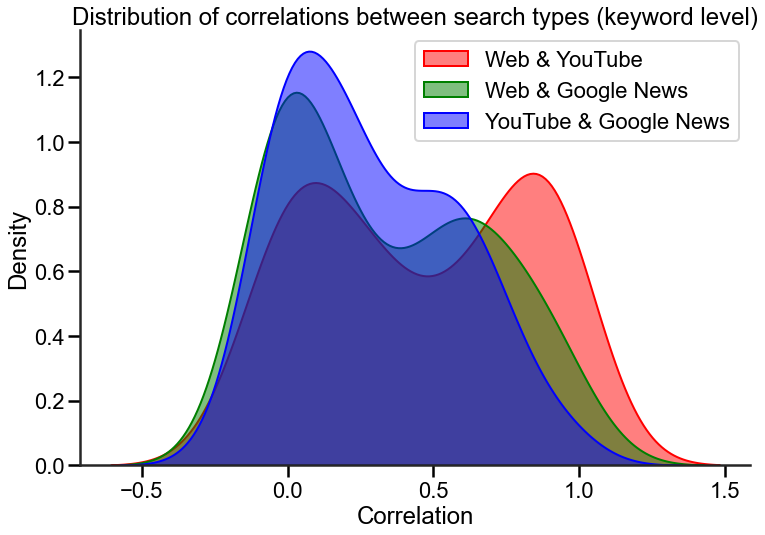

In [15]:
def get_cor_for_uid(df):
    uids = set(df['kwe'].tolist())
    all_cors = []
    for uid in uids:
        all_cors.append(get_cor_for_uid_helper(df, uid))
    df = pd.DataFrame(all_cors)
    df.columns = ['event', 'kw', "web_news", "web_yt", "yt_news"]
    df['kwe'] = df['kw'] + "_" + df['event']
    return df 


def get_cor_for_uid_helper(df, uid):
    cors = []
    kw = uid.split("_")[0]
    event = "_".join(uid.split("_")[1:])
    a = df[df['kwe'] == uid]
    pivot_df = a.pivot_table(index='date', columns='search_type', values='value')
    l = pivot_df.corr().to_dict()
    row = [event, kw, l['web']['google_news'],l['web']['youtube'],l['youtube']['google_news']]
    return row

cor_df = get_cor_for_uid(df)


# PLOT CORRELATIONS
################
make_aesthetic()
# Create a histogram for each correlation using seaborn's 'kdeplot' function
sns.kdeplot(data=cor_df['web_yt'], label='Web & YouTube', shade=True, alpha=0.5, color='red')
sns.kdeplot(data=cor_df['web_news'], label='Web & Google News', shade=True, alpha=0.5, color='green')

sns.kdeplot(data=cor_df['yt_news'], label='YouTube & Google News', shade=True, alpha=0.5, color='blue')
sns.despine()

# Add title and labels to the plot
plt.title('Distribution of correlations between search types (keyword level)')
plt.xlabel('Correlation')
plt.ylabel('Density')

# Display the legend
plt.legend(loc='upper right')

# Show the plot
################
plt.savefig(f"{OUTPUT_PATH}cors.png", dpi=300, bbox_inches='tight')
plt.show()


# Mixed Model (use R for any real analysis)

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
df['kwe'] = df['kw'] + df['event']
tdf = df.query("control_period!=999")
md = smf.mixedlm("value ~ C(year) + C(period) * C(search_type, Treatment('web'))", tdf, groups=tdf['kwe']).fit()
ols = smf.ols("value ~ C(year) + C(event) + C(period)*C(search_type, Treatment('web'))", tdf).fit()

## Mixed model, random intercepts for event#KW

In [12]:
md.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                         Mixed Linear Model Regression Results
========================================================================================================================
Model:                                 MixedLM                      Dependent Variable:                      value      
No. Observations:                      16314                        Method:                                  REML       
No. Groups:                            64                           Scale:                                   319.2437   
Min. group size:                       204                          Log-Likelihood:                          -70277.5572
Max. group size:                       351                          Converged:                               Yes        
Mean group size:                       254.9                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  61.716    5.768  10.700 0.000  50.412  73.021
C(year)[T.2017]                                                             2.248    5.642   0.398 0.690  -8.811  13.307
C(year)[T.2018]                                                             3.402    5.528   0.615 0.538  -7.433  14.237
C(year)[T.2019]                                                            10.168    5.687   1.788 0.074  -0.979  21.314
C(year)[T.2020]                                                             3.258    6.033   0.540 0.589  -8.566  15.082
C(period)[T.control]                                                      -58.496    2.247 -26.034 0.000 -62.900 -54.093
C(period)[T.rumor_period]                                                 -58.875    3.159 -18.640 0.000 -65.066 -52.684
C(search_type, Treatment('web'))[T.google_news]                           -27.031    3.159  -8.558 0.000 -33.222 -20.841
C(search_type, Treatment('web'))[T.youtube]                               -32.844    3.159 -10.398 0.000 -39.034 -26.653
C(period)[T.control]:C(search_type, Treatment('web'))[T.google_news]       29.735    3.178   9.358 0.000  23.507  35.963
C(period)[T.rumor_period]:C(search_type, Treatment('web'))[T.google_news]  32.937    4.467   7.374 0.000  24.183  41.692
C(period)[T.control]:C(search_type, Treatment('web'))[T.youtube]           35.832    3.178  11.277 0.000  29.604  42.060
C(period)[T.rumor_period]:C(search_type, Treatment('web'))[T.youtube]      32.984    4.467   7.384 0.000  24.230  41.739
Group Var                                                                  55.300    0.585                              
========================================================================================================================

"""

## OLS, event fe

In [13]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     63.57
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:01:29   Log-Likelihood:                -70872.
No. Observations:               16314   AIC:                         1.418e+05
Df Residuals:                   16280   BIC:                         1.421e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================================
                                                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -1.748e+12   9.68e+12     -0.181      0.857   -2.07e+13    1.72e+13
C(year)[T.2017]                                                            2.014e+12    1.2e+13      0.168      0.866   -2.15e+13    2.55e+13
C(year)[T.2018]                                                            2.718e+12      2e+13      0.136      0.892   -3.65e+13    4.19e+13
C(year)[T.2019]                                                            2.177e+12   3.04e+13      0.072      0.943   -5.74e+13    6.18e+13
C(year)[T.2020]                                                            1.748e+12   9.68e+12      0.181      0.857   -1.72e+13    2.07e+13
C(event)[T.Andrew_Director_2018]                                          -9.708e+11   1.46e+13     -0.066      0.947   -2.96e+13    2.77e+13
C(event)[T.Bernie_campaign_2019]                                          -4.291e+11   2.76e+13     -0.016      0.988   -5.46e+13    5.37e+13
C(event)[T.Bill_campaign_2019]                                            -4.291e+11   2.76e+13     -0.016      0.988   -5.46e+13    5.37e+13
C(event)[T.Elizabeth_campaign_2018]                                       -9.708e+11   1.46e+13     -0.066      0.947   -2.96e+13    2.77e+13
C(event)[T.Impeachment_Ukraine_2019]                                      -4.291e+11   2.76e+13     -0.016      0.988   -5.46e+13    5.37e+13
C(event)[T.James_Director_2017]                                           -2.663e+11   4.26e+12     -0.062      0.950   -8.62e+12    8.09e+12
C(event)[T.Jeff_General_2018]                                             -9.708e+11   1.46e+13     -0.066      0.947   -2.96e+13    2.77e+13
C(event)[T.Joe_pick_2020]                                                    -2.2012      0.916     -2.404      0.016      -3.996      -0.407
C(event)[T.John_Advisor_2018]                                             -9.708e+11   1.46e+13     -0.066      0.947   -2.96e+13    2.77e+13
C(event)[T.John_Staff_2017]                                               -2.663e+11   4.26e+12     -0.062      0.950   -8.62e+12    8.09e+12
C(event)[T.Justice_retirement_2018]                                       -9.708e+11   1.46e+13     -0.066      0.947   -2.96e+13    2.77e+13
C(event)[T.Kirstjen_Security_2019]                                        -4.291e+11   2.76e+13     -0.016      0.988   -5.46e+13    5.37e+13
C(event)[T.Merrick_Court_2016]                                             1.748e+12   9.68e+12      0.181      0.857   -1.72e+13    2.07e+13
C(event)[T.Michael_Advisor_2017]                                          -2.663e+11   4.26e+12     -

# scrap

Is all of this confounded by how long the rumor-announcement gaps are and is there some kind of time trend?

In [14]:
df['rumor_announce_gap'] = (pd.to_datetime(df['announce_day']) - pd.to_datetime(df['rumor_day'])).dt.days.astype(int)
df['max_date'] = df.groupby("event")['date'].transform('max')
df['min_date'] = df.groupby("event")['date'].transform('min')
df['study_duration'] = (pd.to_datetime(df['max_date']) - pd.to_datetime(df['min_date'])).dt.days.astype(int)
df['per_value'] = df.groupby(by=['event', 'period'])['value'].transform('mean')
df['per2_value'] = df.groupby(by=['event', 'period2'])['value'].transform('mean')
df['year'] = pd.to_datetime(df['announce_day']).dt.year


In [15]:
tdf = df.copy()
for col in ['event', 'study_duration', 'rumor_announce_gap', 'period2']:
    if pd.api.types.is_categorical_dtype(tdf[col]):
        tdf[col] = tdf[col].astype('object')
a = tdf.pivot_table(index=['event', 'study_duration', 'rumor_announce_gap', 'year'], values='value', columns=['period'])
a['rumor_to_control'] = (a['rumor_period']+1) / (a['control']+1)
a['announce_to_control'] = (a['announce_period']+1) / (a['control']+1)
a['announce_rumor_rat'] = (a['announce_to_control']+1)/ (a['rumor_to_control']+1)
a = a.reset_index()

In [16]:
a

period,event,study_duration,rumor_announce_gap,year,announce_period,control,rumor_period,rumor_to_control,announce_to_control,announce_rumor_rat
0,Amy_Court_2020,67,7,2020,37.416667,9.008838,38.333333,3.929860,3.838274,0.981422
1,Andrew_Director_2018,106,46,2018,14.166667,5.625397,19.000000,3.018687,2.289171,0.818469
2,Bernie_campaign_2019,90,30,2019,54.888889,10.352060,1.000000,0.176179,4.923238,5.035998
3,Bill_campaign_2019,91,31,2019,84.166667,7.327778,6.166667,0.860574,10.226818,6.034062
4,Elizabeth_campaign_2018,116,56,2019,36.333333,9.726087,3.833333,0.450615,3.480611,3.088767
5,Impeachment_Ukraine_2019,71,11,2019,60.777778,23.685714,18.888889,0.805684,2.502572,1.939748
6,James_Director_2017,74,14,2017,53.166667,6.319635,0.000000,0.136619,7.400187,7.390505
7,Jeff_General_2018,81,21,2018,100.000000,6.016667,1.333333,0.332542,14.394299,11.552585
8,Joe_pick_2020,93,33,2020,49.666667,7.107488,2.222222,0.397438,6.249367,5.187613
9,John_Advisor_2018,90,30,2018,37.333333,7.494382,23.833333,2.923501,4.512787,1.405068


In [17]:
a.corr()

period,study_duration,rumor_announce_gap,year,announce_period,control,rumor_period,rumor_to_control,announce_to_control,announce_rumor_rat
period,,,,,,,,,
study_duration,1.000000,1.000000,0.231597,-0.143787,-0.218625,-0.197864,-0.022696,-0.120011,-0.112030
rumor_announce_gap,1.000000,1.000000,0.231597,-0.143787,-0.218625,-0.197864,-0.022696,-0.120011,-0.112030
year,0.231597,0.231597,1.000000,0.157148,0.357495,0.415780,0.268142,-0.097364,-0.206474
announce_period,-0.143787,-0.143787,0.157148,1.000000,0.013125,-0.115184,-0.173663,0.856741,0.746623
control,-0.218625,-0.218625,0.357495,0.013125,1.000000,0.348465,-0.095488,-0.449199,-0.367540
rumor_period,-0.197864,-0.197864,0.415780,-0.115184,0.348465,1.000000,0.882335,-0.272359,-0.540062
rumor_to_control,-0.022696,-0.022696,0.268142,-0.173663,-0.095488,0.882335,1.000000,-0.120182,-0.471677
announce_to_control,-0.120011,-0.120011,-0.097364,0.856741,-0.449199,-0.272359,-0.120182,1.000000,0.870909
announce_rumor_rat,-0.112030,-0.112030,-0.206474,0.746623,-0.367540,-0.540062,-0.471677,0.870909,1.000000


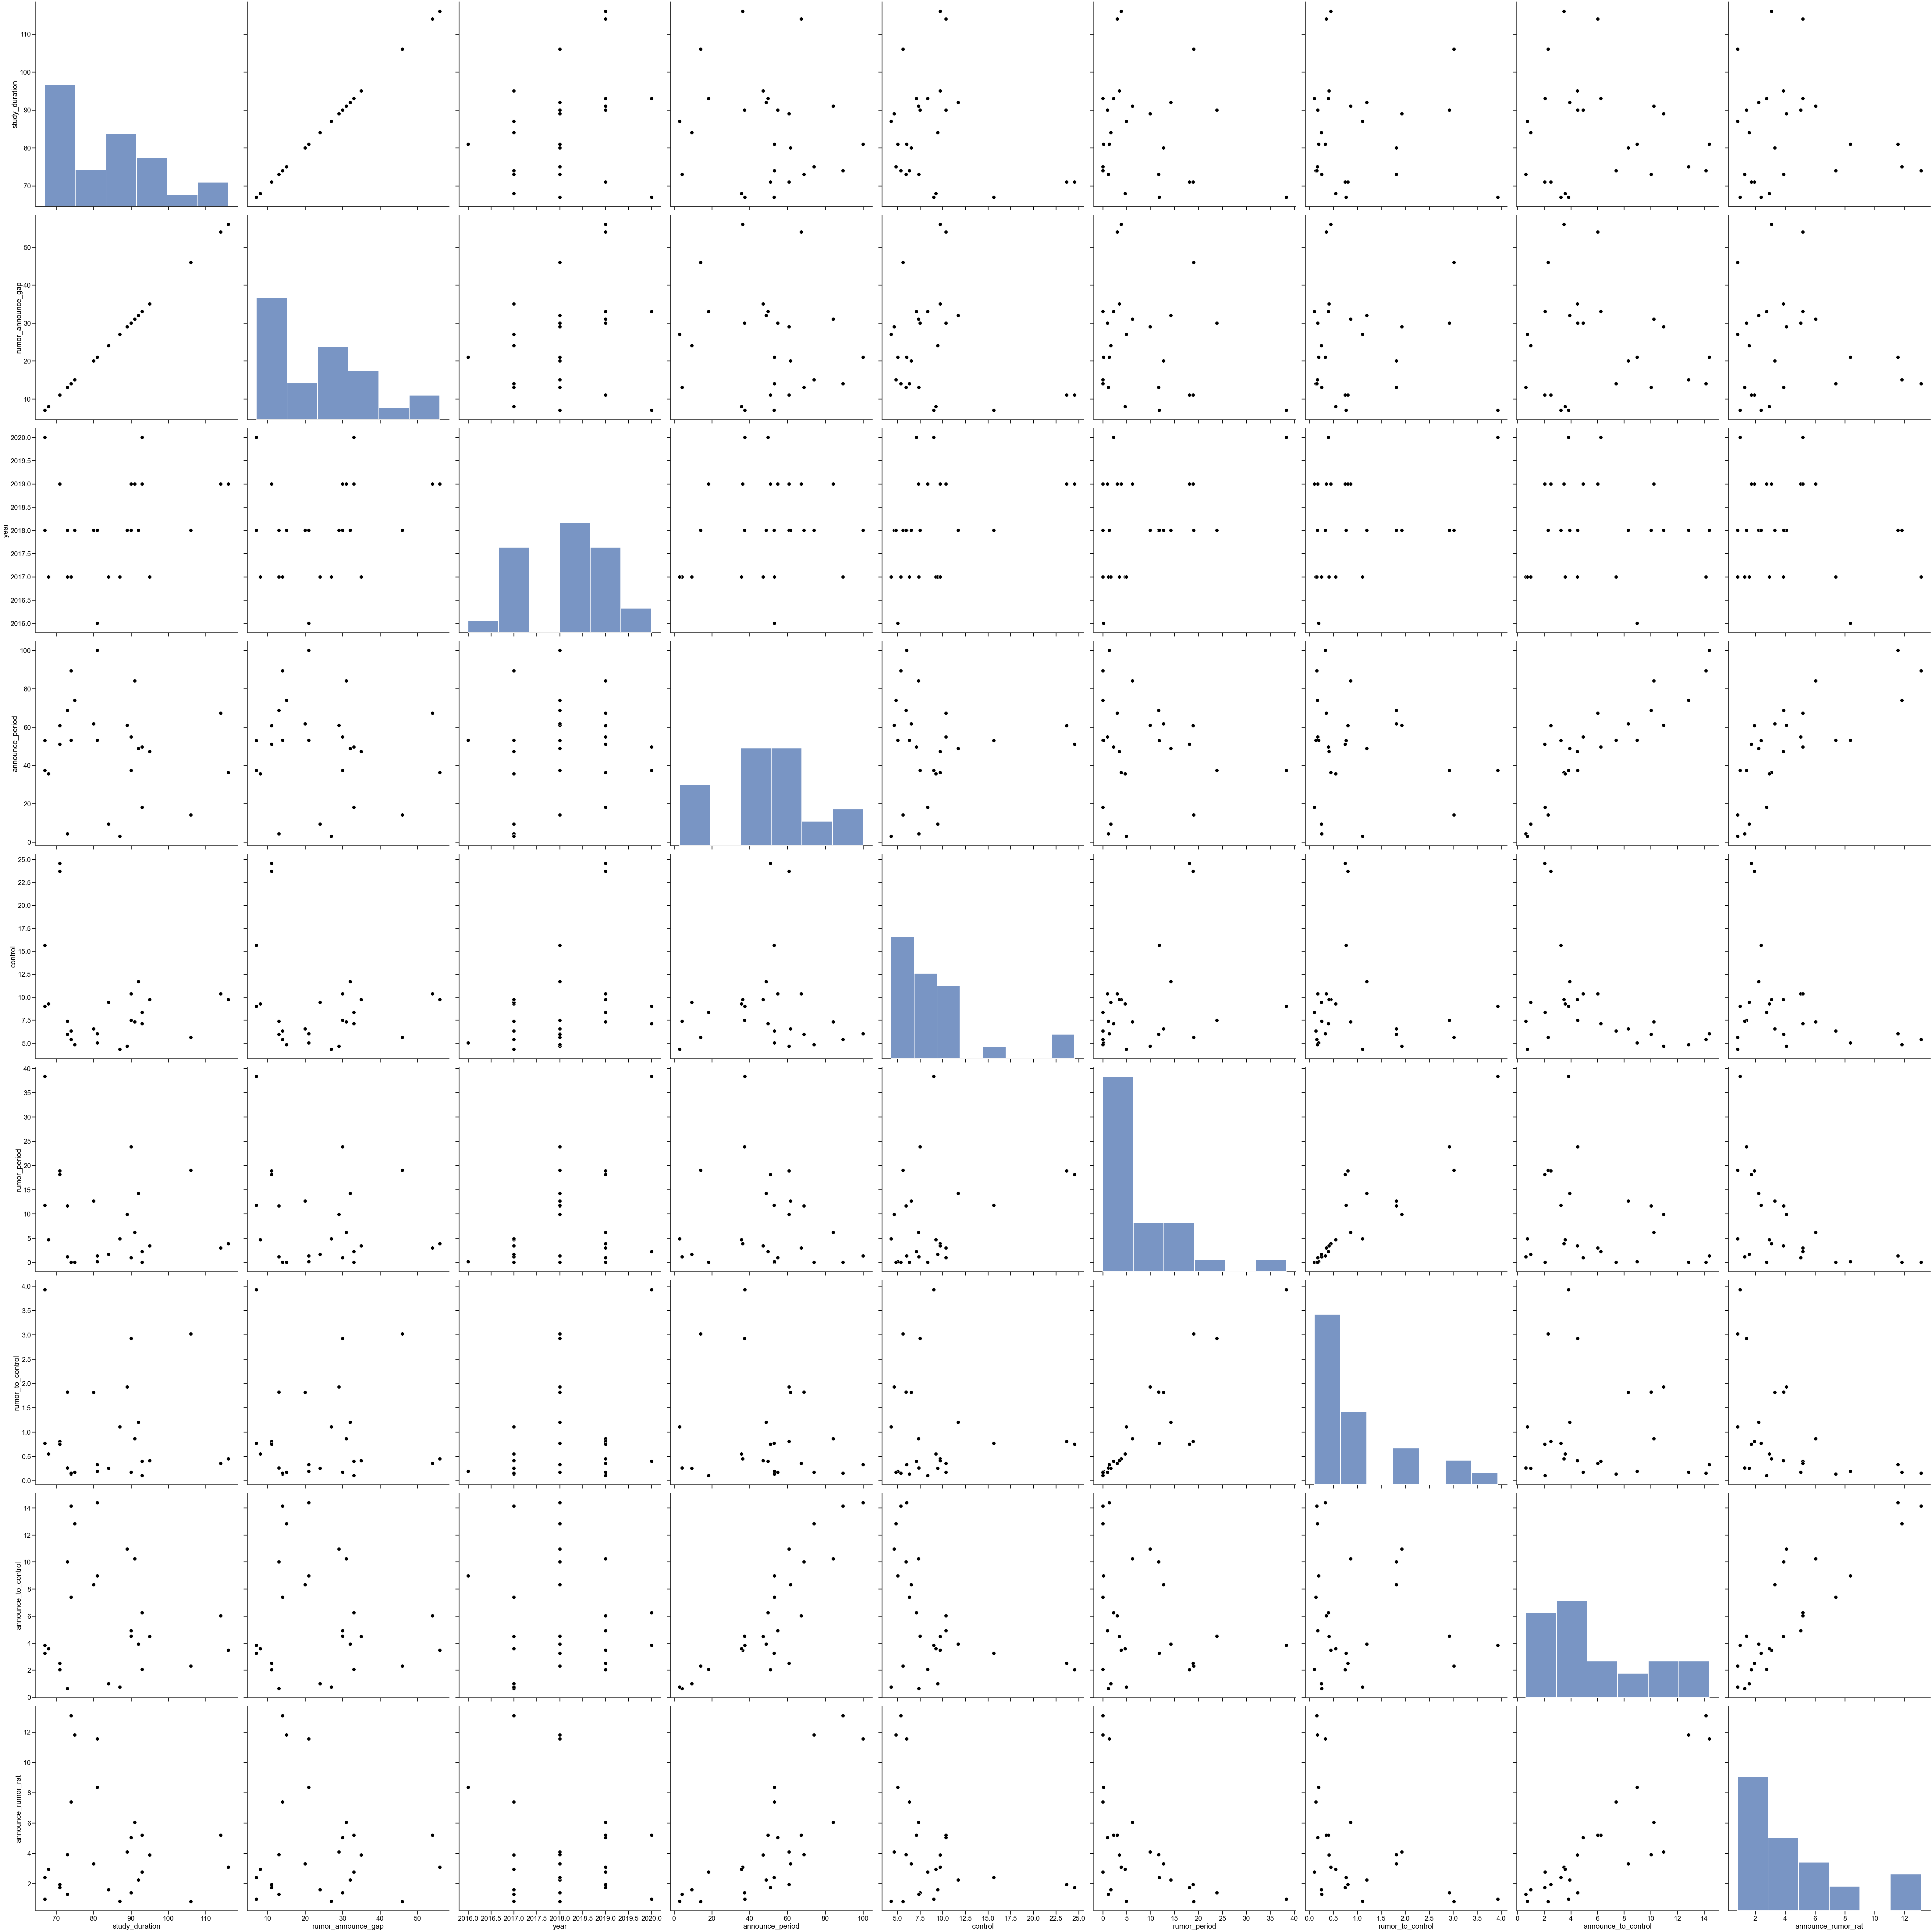

In [18]:
make_aesthetic()
sns.pairplot(a, height=10)

In [19]:
b = tdf.pivot_table(index=['event', 'study_duration', 'rumor_announce_gap', 'year', 'search_type'], values='value', columns=['period'])
b['rumor_to_control'] = (b['rumor_period']+1) / (b['control']+1)
b['announce_to_control'] = (b['announce_period']+1) / (b['control']+1)
b['announce_rumor_rat'] = (b['announce_to_control']+1)/ (b['rumor_to_control']+1)
b = b.reset_index()
b

period,event,study_duration,rumor_announce_gap,year,search_type,announce_period,control,rumor_period,rumor_to_control,announce_to_control,announce_rumor_rat
0,Amy_Court_2020,67,7,2020,web,69.750000,11.250000,25.750000,2.183673,5.775510,2.128205
1,Amy_Court_2020,67,7,2020,google_news,35.750000,9.363636,59.250000,5.813596,3.546053,0.667203
2,Amy_Court_2020,67,7,2020,youtube,6.750000,6.412879,30.000000,4.181911,1.045478,0.394734
3,Andrew_Director_2018,106,46,2018,web,18.000000,2.533333,17.500000,5.235849,5.377358,1.022693
4,Andrew_Director_2018,106,46,2018,google_news,24.500000,7.923810,29.500000,3.417823,2.857524,0.873173
...,...,...,...,...,...,...,...,...,...,...,...
73,Steve_Council_2017,95,35,2017,google_news,33.333333,11.088652,6.666667,0.634204,2.840129,2.349847
74,Steve_Council_2017,95,35,2017,youtube,13.000000,11.741135,0.000000,0.078486,1.098803,1.946065
75,Withdrawal_Syria_2018,67,7,2018,web,64.000000,14.090909,6.666667,0.508032,4.307229,3.519308
76,Withdrawal_Syria_2018,67,7,2018,google_news,49.333333,14.075758,5.666667,0.442211,3.338693,3.008362


<AxesSubplot:xlabel='year', ylabel='value'>

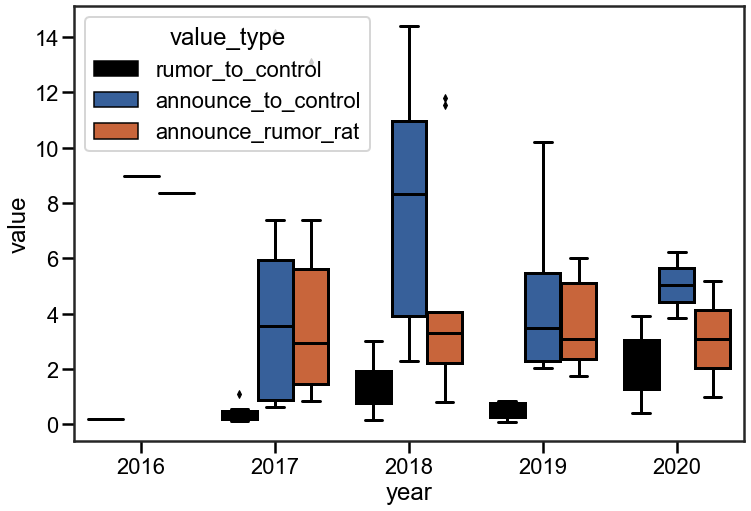

In [23]:
melted = pd.melt(a, id_vars=['event', 'year', 'rumor_announce_gap'], 
                 value_vars=['rumor_to_control', 'announce_to_control', 'announce_rumor_rat'], 
                 var_name = 'value_type', 
                 value_name = 'value')
sns.boxplot(data=melted, x='year', y='value', hue='value_type')

# Test whether different platforms to lag/lead others

Instead of VAR model, we are only interested in the sign of the lags: Are web searches led by other sources?

So for each (platform, web) combo, let's compute the cross-correlation function for `platform` and then pos and neg lags for `web`. Then use a permutation test to assess if positive lags are more significant than negative lags.

In [ ]:
from scipy.signal import correlate
import numpy as np

import numpy as np
from scipy import stats

def perm_test(x, y, alternative='greater', num_permutations=10000):
    """Conducts a permutation test from two arrays, testing if positive lags have higher CCF than negative lags"""
    np.random.seed(416)
    observed_statistic = np.mean(y[x > 0]) - np.mean(y[x <= 0])

    # Shuffle the ys while keeping the xs fixed, and compute the test statistic for each permutation
    permutation_statistics = np.zeros(num_permutations)
    for i in range(num_permutations):
        ys_permuted = np.random.permutation(y)
        permutation_statistics[i] = np.mean(ys_permuted[x > 0]) - np.mean(ys_permuted[x <= 0])

    # Compute the p-value
    if alternative == 'greater':
        p_value = np.mean(permutation_statistics >= observed_statistic)
    elif alternative == 'less':
        p_value = np.mean(permutation_statistics <= observed_statistic)

    return p_value, observed_statistic


def compute_cross_cors(df):
    cross_cor_dfs = []
    list_events = list(set(df['event'].tolist()))
    comparisons = [['youtube', 'web'], 
                   ['google_news', 'web'], 
                   ['youtube', 'google_news']
                ]
    for l in list_events:
        for compare in comparisons:
            cross_cor_dfs.append(compute_cross_cor(df, l, compare[0], compare[1]))
    return pd.concat(cross_cor_dfs)
    
def compute_cross_cor(df, e, s1, s2, graph=False):
    tdf = df.query("event=='{}'".format(e))
    array1 = np.array(tdf.query("search_type=='{}'".format(s1))['value'].tolist())
    array2 = np.array(tdf.query("search_type=='{}'".format(s2))['value'].tolist())

    # Calculate the cross-correlation function
    ccf = correlate(array1 - array1.mean(), array2 - array2.mean(), mode='full')

    # Normalize the cross-correlation function
    ccf_norm = ccf / np.max(ccf)

    # Calculate the time lags for the cross-correlation values
    time_lags = np.arange(-len(array2)+1, len(array2))
    p = perm_test(array1, array2,'greater')
    cross_cor_df = pd.DataFrame({'lags':time_lags, 'ccf':ccf_norm, 'event':e, 's':f"{s1}_{s2}", 'p':p[0], 'o':p[1]})
    
    # Plot the normalized cross-correlation function
    if graph:
        plt.plot(time_lags, ccf_norm)
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.xlabel('Time Lag (Days)')
        plt.ylabel('Normalized Cross-correlation')
        plt.title(e, s1, s2)
        plt.show()
    return cross_cor_df                    


cd = compute_cross_cors(event_search)

In [24]:
event_search

,event,date,search_type,rumor_day,rumor_day2,announce_day,rumor_delta,announce_delta,value,rumor2_delta,...,study_duration,n_event_kws,rumor_period,announce_period,rumor2_period,control_period,control_period2,period,period2,year
0,Amy_Court_2020,2020-08-20,google_news,2020-09-19,2020-09-19,2020-09-26,-30,-37,0.000000,-30.0,...,67.0,4.0,0,0,0,1,1,control,control,2020
1,Amy_Court_2020,2020-08-20,google_news,2020-09-19,2020-09-22,2020-09-26,-30,-37,0.000000,-33.0,...,67.0,4.0,0,0,0,1,1,control,control,2020
2,Amy_Court_2020,2020-08-20,web,2020-09-19,2020-09-19,2020-09-26,-30,-37,3.000000,-30.0,...,67.0,4.0,0,0,0,1,1,control,control,2020
3,Amy_Court_2020,2020-08-20,web,2020-09-19,2020-09-22,2020-09-26,-30,-37,0.000000,-33.0,...,67.0,4.0,0,0,0,1,1,control,control,2020
4,Amy_Court_2020,2020-08-20,youtube,2020-09-19,2020-09-19,2020-09-26,-30,-37,1.333333,-30.0,...,67.0,4.0,0,0,0,1,1,control,control,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13198,Withdrawal_Syria_2018,2019-01-18,web,2018-12-12,2018-12-14,2018-12-19,37,30,15.000000,35.0,...,67.0,3.0,0,0,0,1,1,control,control,2018
13199,Withdrawal_Syria_2018,2019-01-18,web,2018-12-12,2018-12-15,2018-12-19,37,30,38.000000,34.0,...,67.0,3.0,0,0,0,1,1,control,control,2018
13200,Withdrawal_Syria_2018,2019-01-18,youtube,2018-12-12,2018-12-12,2018-12-19,37,30,0.000000,37.0,...,67.0,3.0,0,0,0,1,1,control,control,2018
13201,Withdrawal_Syria_2018,2019-01-18,youtube,2018-12-12,2018-12-14,2018-12-19,37,30,49.000000,35.0,...,67.0,3.0,0,0,0,1,1,control,control,2018


In [ ]:
for s in cd['s'].unique():
    tcd = cd.query("s=='{}'".format(s))
    print(s)
    print("Percent of stories p <= 0.05")
    print(np.mean(np.array(tcd.drop_duplicates("event")['p']) <= 0.05))
    print("FULL SAMPLE (p, observed diff)")
    print(perm_test(tcd['lags'], tcd['ccf'], 'greater'))
    print("\n"*2)

In [ ]:
df4 = df.groupby(by=['event', 'search_type', 'period2']).mean()['value'].reset_index()

In [ ]:
df_pivot = pd.pivot_table(df4, values='value', index='event',
                          columns=['search_type', 'period2'], aggfunc=np.mean)

# Flatten the column headers
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]

# Reset the index to make the 'event' column a regular column
df_pivot = df_pivot.reset_index()

# Optionally, rename the 'event' column
df_pivot = df_pivot.rename(columns={'event': 'Event'})



In [ ]:
sns.heatmap(np.round(df_pivot.corr(),2), annot=True)

In [ ]:
md = smf.ols("web_announce_period ~ web_control + web_rumor2_period + google_news_announce_period + google_news_control + google_news_rumor2_period + youtube_announce_period + youtube_control + youtube_rumor2_period", df_pivot).fit()


In [ ]:
md.summary()

In [ ]:
df.groupby(by=['period2', 'search_type']).mean()

In [ ]:
make_aesthetic()
sns.scatterplot(data=df_pivot, y='web_announce_period', x='google_news_announce_period')